In [1]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')

C:\Users\Almalis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def Preprocess(JsonFile,number_of_sector,text_Sector,Csvname):
    with open(JsonFile,"r") as fp:
    #with open("General_Market.json",encoding='utf8') as fp:
        json_d = json.load(fp)

    ticks_d = json_d['data']
    df = pd.DataFrame(ticks_d)

    X= pd.DataFrame(columns=['Article','Target'])
    X['Article']=df['title']+" "+df['text']
    X['Target']=number_of_sector




    print("Number of Examples in ",text_Sector," : ",len(X),"\n")
    X.drop_duplicates(inplace=True)
    X.index = range(len(X))
    print("Number of Examples after removing duplicates: ",len(X),"\n")

    print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
    X['Article']=clean_data(X['Article'])
    print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
    print("\n*****************************************************************************\n")
    
    X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
    for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
        X['Article'][i] = ' '.join(X['Article'][i])
    
    #Xv = X['Article'].to_frame()
    X.to_csv (Csvname, index = False, header=True)


In [4]:
#Technology=0,Health=1,Financial=2,Consumer=3,Energy=4,Commodity=5

Preprocess('Technology_news.json',0,'Technology news','Technology.csv')
Preprocess('Health_news.json',1,'Health news','Health.csv')
Preprocess('Financial_news.json',2,'Financial news','Financial.csv')
Preprocess('Consumer_news.json',3,'Consumer news','Consumer.csv')
Preprocess('Energy_news.json',4,'Energy news','Energy.csv')
Preprocess('Commodity_news.json',5,'Commodity news','Commodity.csv')

Tech_df = pd.read_csv("Technology.csv")
Health_df=pd.read_csv("Health.csv")
Financial_df=pd.read_csv("Financial.csv")
Consumer_df=pd.read_csv("Consumer.csv")
Energy_df=pd.read_csv("Energy.csv")
Commodity_df=pd.read_csv("Commodity.csv")

New_pd = pd.concat([Tech_df,Health_df], ignore_index=True)
New_pd2 = pd.concat([Financial_df,Consumer_df], ignore_index=True)
New_pd3 = pd.concat([Energy_df,Commodity_df], ignore_index=True)
New_pd = pd.concat([New_pd,New_pd2], ignore_index=True)
New_pd = pd.concat([New_pd,New_pd3], ignore_index=True)

New_pd.index = range(len(New_pd))

New_pd = New_pd.sample(frac=1).reset_index(drop=True)

Names=['Technology','Health','Financial','Consumer','Energy','Commodity']
Values=[]

for i in range(6):
    Values.append((New_pd['Target']==i).sum())
    print('Number of ',Names[i],' examples : ',Values[i])
    


Number of Examples in  Technology news  :  27387 

Number of Examples after removing duplicates:  26934 

Number of words before cleaning :  985859
Number of words after cleaning :  659009

*****************************************************************************

Number of Examples in  Health news  :  19238 

Number of Examples after removing duplicates:  18013 

Number of words before cleaning :  757677
Number of words after cleaning :  506572

*****************************************************************************

Number of Examples in  Financial news  :  20000 

Number of Examples after removing duplicates:  19270 

Number of words before cleaning :  751401
Number of words after cleaning :  496665

*****************************************************************************

Number of Examples in  Consumer news  :  21240 

Number of Examples after removing duplicates:  20279 

Number of words before cleaning :  714316
Number of words after cleaning :  467897

**********

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=5)
Xv = tfidf_vectorizer.fit_transform(New_pd['Article'].values.astype('U')) 

    
Xv = pd.DataFrame(Xv.todense())
X_train,X_test,y_train,y_test = train_test_split(Xv,New_pd['Target'], test_size=0.3,stratify=New_pd['Target'])

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

## Naive Bayes 


Metrics

 Recall metric: 0.8590502477154408
 F1 metric: 0.8306994607813166
 Precision metric: 0.812077843687717
 Accuracy metric: 0.843429339749487
 Balanced Accuracy metric: 0.8590502477154408 

**************************************************

Normalized confusion matrix
[[0.859 0.016 0.047 0.052 0.013 0.013]
 [0.013 0.833 0.058 0.063 0.016 0.016]
 [0.032 0.027 0.812 0.064 0.038 0.027]
 [0.035 0.025 0.076 0.831 0.016 0.018]
 [0.003 0.008 0.045 0.011 0.924 0.008]
 [0.005 0.008 0.045 0.023 0.024 0.894]]


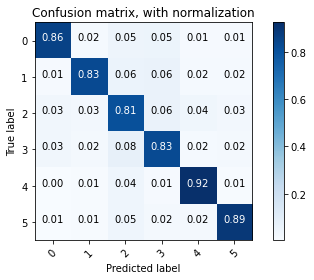

In [7]:
alpha = 0.6 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(X_train,y_train)
y_predicted = model.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0, 1, 2, 3, 4, 5])
np.set_printoptions(precision=3)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5],
                  title='Confusion matrix, with normalization')


## Random Forest


Metrics with OverSampling

 Recall metric: 0.797915135843461
 F1 metric: 0.7997098448964693
 Precision metric: 0.8033910380846224
 Accuracy metric: 0.7812964404500743
 Balanced Accuracy metric: 0.797915135843461 

**************************************************

Normalized confusion matrix
[[0.853 0.036 0.044 0.058 0.003 0.006]
 [0.095 0.786 0.047 0.064 0.002 0.006]
 [0.117 0.043 0.731 0.074 0.02  0.015]
 [0.155 0.059 0.083 0.692 0.003 0.008]
 [0.02  0.013 0.07  0.016 0.875 0.006]
 [0.047 0.021 0.034 0.038 0.009 0.851]]


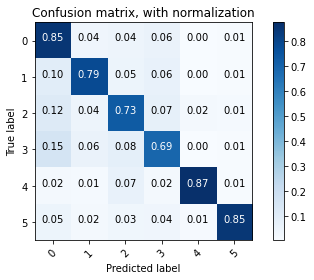

In [9]:
model2 = RandomForestClassifier(n_estimators=30, max_features="auto", n_jobs=-1,class_weight='balanced')
model2.fit(X_train,y_train)
y_predicted = model2.predict(X_test)

print("\nMetrics with OverSampling\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0, 1, 2, 3, 4, 5])
np.set_printoptions(precision=3)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5],
                  title='Confusion matrix, with normalization')